In [61]:
import os

import numpy as np

import matplotlib.pyplot as plt

import cv2

from skimage import io, color, data, transform
from sklearn.datasets import fetch_lfw_people
from skimage.feature import hog

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.image import PatchExtractor

from itertools import chain  

import joblib

from TIPEutils import sliding_window

model_patches_shape = (62, 47)

# Chargement du modèle à améliorer
filename = 'model_03.sav'
loaded_model = joblib.load(filename)

In [64]:
folder_path = "img/neg2"

file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith('.jpg')]

imgs_to_use = [color.rgb2gray(cv2.imread("img/neg2/{}".format(file_name))) for file_name in file_names]

In [65]:
def extract_patches(img, N, scale=1.0, patch_size=model_patches_shape):
    ''' Extrait des patches d'une image
    '''
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negatives_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in imgs_to_use for scale in [0.5, 1.0, 2.0]])

In [66]:
len(negatives_patches)

84000

[31909 40090 33552 ... 70419 67132 43789]


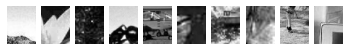

In [67]:
sample_size = 84000
sample_indices = np.random.permutation(negatives_patches.shape[0])[:sample_size]
print(sample_indices)
sample = negatives_patches[sample_indices]

fig, axs = plt.subplots(1, 10)
for i in range(10):
    axs[i].imshow(sample[i], cmap='gray')
    axs[i].axis('off')

17 hard negative examples


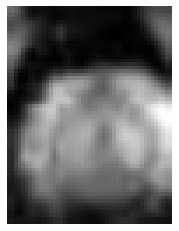

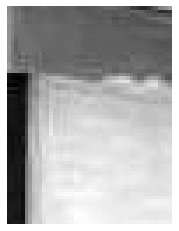

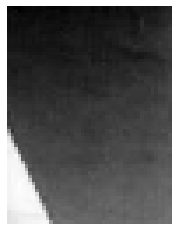

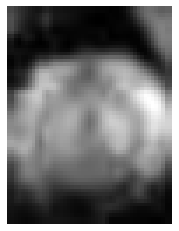

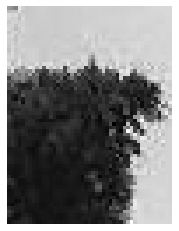

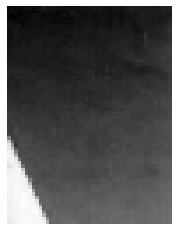

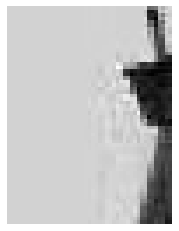

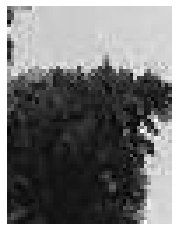

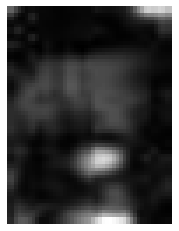

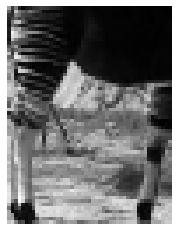

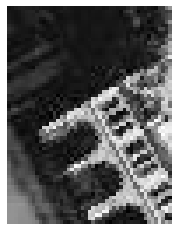

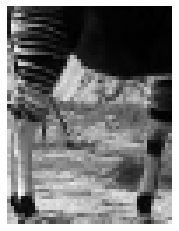

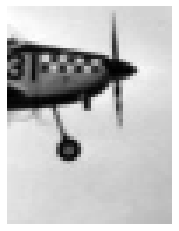

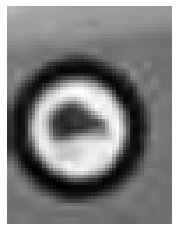

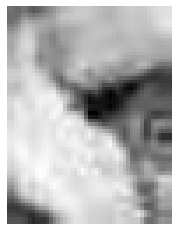

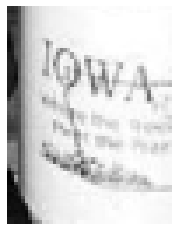

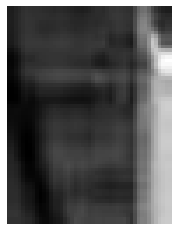

In [68]:
patches_hog = np.array([hog(patch) for patch in sample])

labels = loaded_model.predict(patches_hog)

hard_negatives = []
#hard_negatives_indices = []

conf_seuil = 1

for k in range(len(sample)):
    if labels[k] and loaded_model.decision_function(patches_hog)[k] > conf_seuil:
        hard_negatives.append(sample[k])
        #hard_negatives_indices.append(sample_indices[k])
        
#hard_negatives_indices = np.array(hard_negatives_indices)

hard_negatives = np.array(hard_negatives)

print("{} hard negative examples".format(len(hard_negatives)))

'''
fig, axs = plt.subplots(1, len(hard_negatives_indices))
for (k, i) in enumerate(hard_negatives_indices):
    axs[k].imshow(negatives_patches[i], cmap='gray')
    axs[k].axis('off')
'''

for hn in hard_negatives:
    fig, ax = plt.subplots()
    ax.imshow(hn, cmap='gray')
    ax.axis('off')
    
np.save('hne.npy', hard_negatives)

In [69]:
with open('hne3.npy', 'wb') as f:
    np.save(f, hard_negatives)

La prochaine étape est donc d'entrainer un nouveau SVM avec comme positives examples: les premiers positives examples union ces hard negative examples et comme negatives examples: les premiers negatives examples.


# Ne prendre que ceux avec conf > 0.5

In [84]:
hard_negatives_indices

array([15047, 10763, 24231, 29190, 22090,  9659, 28654, 24291, 10478,
       10847, 27442, 13584, 19621, 21737, 24715, 33645, 12573,  9627,
       19191, 19819, 26488, 23264, 23159, 23878,  9066, 21469, 19064,
       12600, 25725, 21139, 27951, 16191, 33799, 12695, 10817, 24939,
       25368])